# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de Fuerteventura

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    #plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.show()
    
def visualizar_historico(train, y_test, y_pred, variable, dias_historico, indices, tit, color, dif):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    plt.bar(indices, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    historico = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=2)
    
    return modelo, historico
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))
        
def visualizar_perdida(historico):
    plt.plot(historico.history['loss'], label='train')
    plt.plot(historico.history['val_loss'], label='test')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.title('Pérdida del modelo')
    plt.legend()
    plt.show() 

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_Fuerteventura = datos[datos['isla'] == 'FUERTEVENTURA']

datos_Fuerteventura = datos_Fuerteventura.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Fuerteventura'         # Isla a la que se está realziando el estudio
fechas = datos_Fuerteventura.tail(dias_prediccion).index # Fechas de los días a predecir
color_isla = 'tan' # Color de la isla en las visualizaciones
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train


variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                          # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Fuerteventura_uni = datos_Fuerteventura[objetivo]
datos_Fuerteventura_uni_arr = np.array(datos_Fuerteventura_uni).reshape(-1, 1)

datos_Fuerteventura_mult_covid = datos_Fuerteventura[variables_covid]
datos_Fuerteventura_mult_atm = datos_Fuerteventura[variables_atm]
datos_Fuerteventura_mult_total = datos_Fuerteventura[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Fuerteventura_uni_scaled = scaler.fit_transform(datos_Fuerteventura_uni_arr)

In [7]:
n_train = len(datos_Fuerteventura_uni_scaled) - dias_prediccion


train = datos_Fuerteventura_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Fuerteventura_uni_scaled[n_train - dias_prediccion:len(datos_Fuerteventura_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0461 - val_loss: 0.0184 - 3s/epoch - 214ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0406 - val_loss: 0.0172 - 123ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0376 - val_loss: 0.0158 - 118ms/epoch - 8ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0360 - val_loss: 0.0150 - 120ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0329 - val_loss: 0.0141 - 119ms/epoch - 8ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0302 - val_loss: 0.0159 - 119ms/epoch - 8ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0274 - val_loss: 0.0132 - 120ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0213 - val_loss: 0.0112 - 121ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0203 - val_loss: 0.0118 - 120ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0187 - val_loss: 0.0107 - 119ms/epoch - 8ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0195 - val_loss: 0.0109 - 118ms/epoch - 8ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0169 - val_loss: 0.0098 - 119ms/epoch - 8ms/step
Epoch 13/40
14/14 - 0s - l

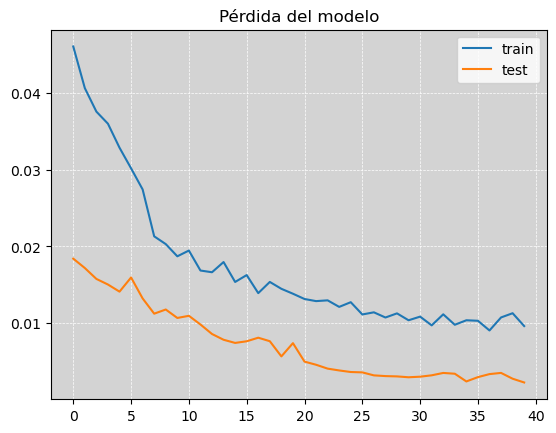

In [10]:
visualizar_perdida(historico)

In [11]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 317ms/step


In [12]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 22, número de casos predichos 24.197775
2022-03-20: número de casos reales 21, número de casos predichos 26.045422
2022-03-21: número de casos reales 28, número de casos predichos 25.329151
2022-03-22: número de casos reales 33, número de casos predichos 23.073887
2022-03-23: número de casos reales 27, número de casos predichos 23.340727
2022-03-24: número de casos reales 28, número de casos predichos 27.083342
2022-03-25: número de casos reales 32, número de casos predichos 28.19203
2022-03-26: número de casos reales 12, número de casos predichos 26.935602
2022-03-27: número de casos reales 6, número de casos predichos 27.113691
2022-03-28: número de casos reales 22, número de casos predichos 25.28856


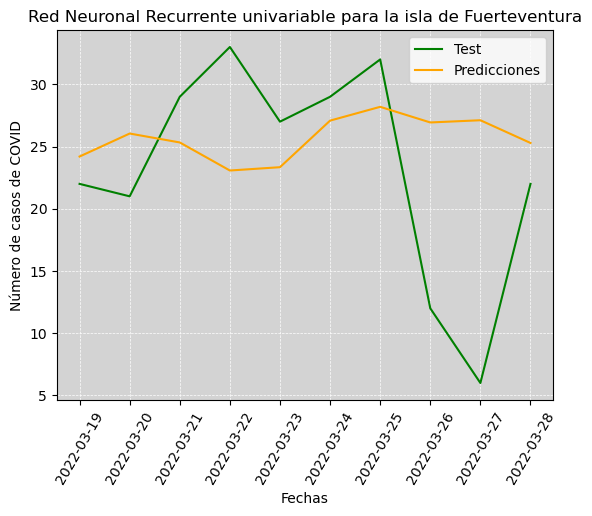

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [14]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([ -2.19777489,  -5.0454216 ,   3.67084885,   9.92611313,
         3.65927315,   1.9166584 ,   3.80797005, -14.93560219,
       -21.11369133,  -3.28856087])

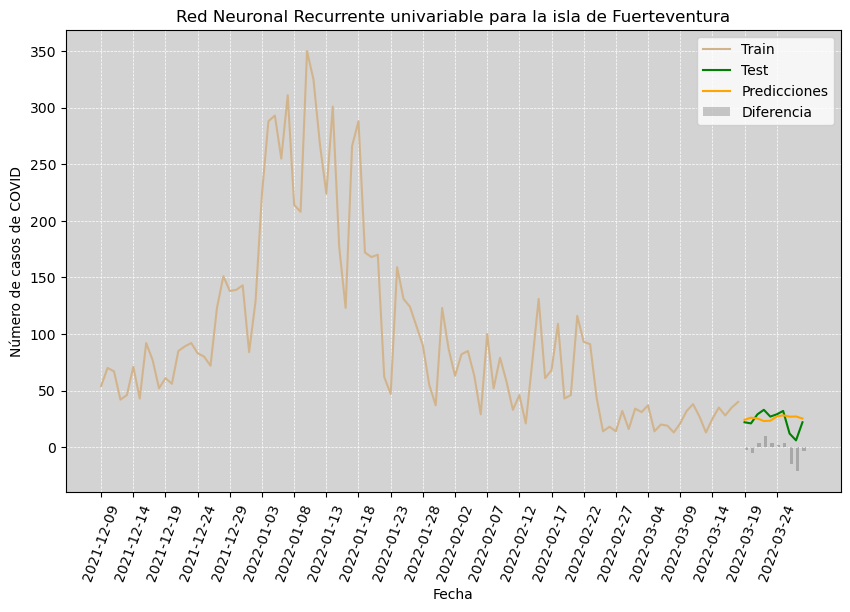

In [15]:
datos_train = datos_Fuerteventura_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',n_dias_train_vis,fechas,tit,color_isla,dif)

In [16]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 85.35286488274687
Error absoluto medio (MAE) del modelo: 6.956191444396973
Raíz del error cuadrático medio (RMSE) del modelo: 9.238661422670866


# Red Neuronal Recurrente multivariable con variables de pandemia

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Fuerteventura_mult_covid_scaled = scaler.fit_transform(datos_Fuerteventura_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Fuerteventura_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Fuerteventura_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_Fuerteventura_mult_covid_scaled) - dias_prediccion


train = datos_Fuerteventura_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Fuerteventura_mult_covid_scaled[n_train - dias_prediccion:len(datos_Fuerteventura_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0435 - val_loss: 0.0208 - 3s/epoch - 215ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0364 - val_loss: 0.0192 - 134ms/epoch - 10ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0295 - val_loss: 0.0181 - 132ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0262 - val_loss: 0.0167 - 131ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0237 - val_loss: 0.0164 - 130ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0227 - val_loss: 0.0147 - 134ms/epoch - 10ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0213 - val_loss: 0.0146 - 132ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0197 - val_loss: 0.0145 - 130ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0196 - val_loss: 0.0125 - 131ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0173 - val_loss: 0.0114 - 130ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0164 - val_loss: 0.0098 - 129ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0167 - val_loss: 0.0106 - 132ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s -

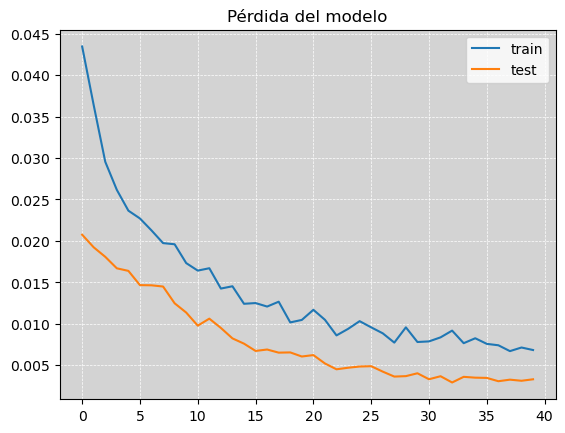

In [21]:
visualizar_perdida(historico)

In [22]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 289ms/step


In [23]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 22, número de casos predichos 10.95672
2022-03-20: número de casos reales 21, número de casos predichos 11.497306
2022-03-21: número de casos reales 28, número de casos predichos 11.304128
2022-03-22: número de casos reales 33, número de casos predichos 11.070877
2022-03-23: número de casos reales 27, número de casos predichos 10.914917
2022-03-24: número de casos reales 28, número de casos predichos 11.169581
2022-03-25: número de casos reales 32, número de casos predichos 11.425058
2022-03-26: número de casos reales 12, número de casos predichos 11.064881
2022-03-27: número de casos reales 6, número de casos predichos 11.341271
2022-03-28: número de casos reales 22, número de casos predichos 11.309855


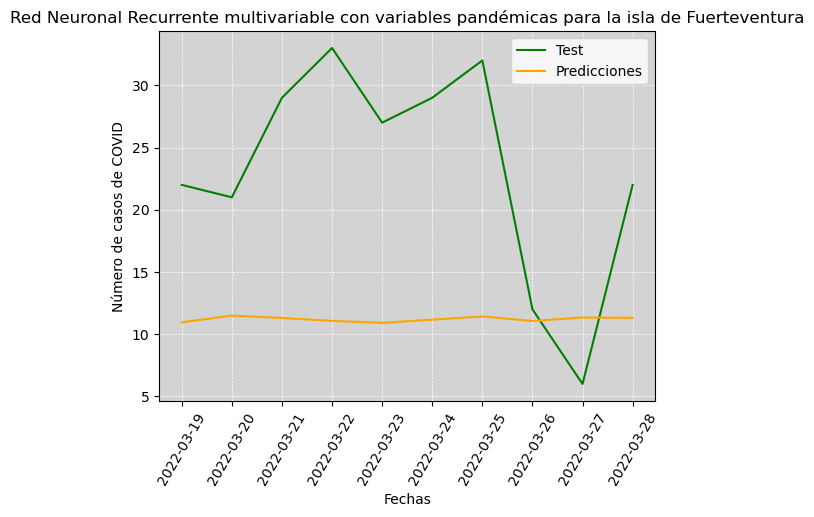

In [24]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [25]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([11.04327965,  9.50269413, 17.69587231, 21.92912292, 16.08508301,
       17.83041859, 20.57494164,  0.93511868, -5.3412714 , 10.69014454])

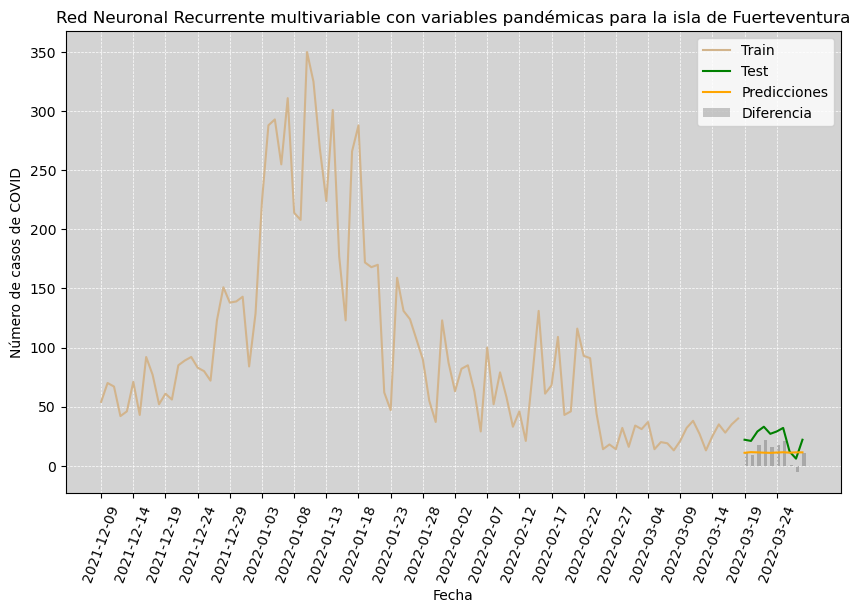

In [26]:
datos_train = datos_Fuerteventura_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [27]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 214.9950313065512
Error absoluto medio (MAE) del modelo: 13.16279468536377
Raíz del error cuadrático medio (RMSE) del modelo: 14.66270886659594


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Fuerteventura_mult_atm_scaled = scaler.fit_transform(datos_Fuerteventura_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Fuerteventura_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Fuerteventura_mult_atm[objetivo]).reshape(-1, 1))

In [29]:
n_train = len(datos_Fuerteventura_mult_atm_scaled) - dias_prediccion


train = datos_Fuerteventura_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Fuerteventura_mult_atm_scaled[n_train - dias_prediccion:len(datos_Fuerteventura_mult_atm_scaled), :]

In [30]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [31]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0471 - val_loss: 0.0205 - 3s/epoch - 207ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0417 - val_loss: 0.0189 - 130ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0357 - val_loss: 0.0176 - 127ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0303 - val_loss: 0.0192 - 126ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0243 - val_loss: 0.0171 - 126ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0232 - val_loss: 0.0143 - 127ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0228 - val_loss: 0.0155 - 129ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0215 - val_loss: 0.0135 - 126ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0199 - val_loss: 0.0109 - 125ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0183 - val_loss: 0.0101 - 127ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0180 - val_loss: 0.0144 - 128ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0169 - val_loss: 0.0126 - 126ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - l

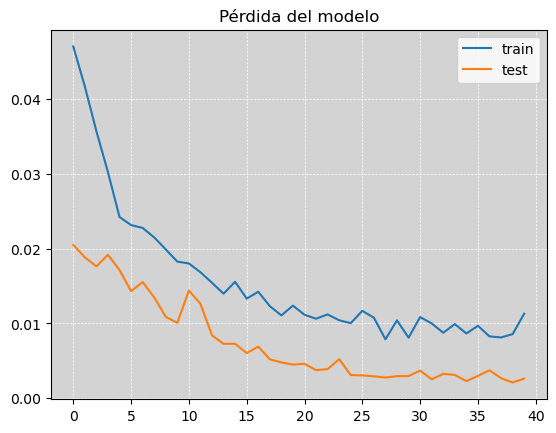

In [32]:
visualizar_perdida(historico)

In [33]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 478ms/step


In [34]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 22, número de casos predichos 29.538263
2022-03-20: número de casos reales 21, número de casos predichos 30.633984
2022-03-21: número de casos reales 28, número de casos predichos 30.629347
2022-03-22: número de casos reales 33, número de casos predichos 30.53703
2022-03-23: número de casos reales 27, número de casos predichos 31.377893
2022-03-24: número de casos reales 28, número de casos predichos 34.18768
2022-03-25: número de casos reales 32, número de casos predichos 34.305374
2022-03-26: número de casos reales 12, número de casos predichos 32.582844
2022-03-27: número de casos reales 6, número de casos predichos 32.04613
2022-03-28: número de casos reales 22, número de casos predichos 30.06066


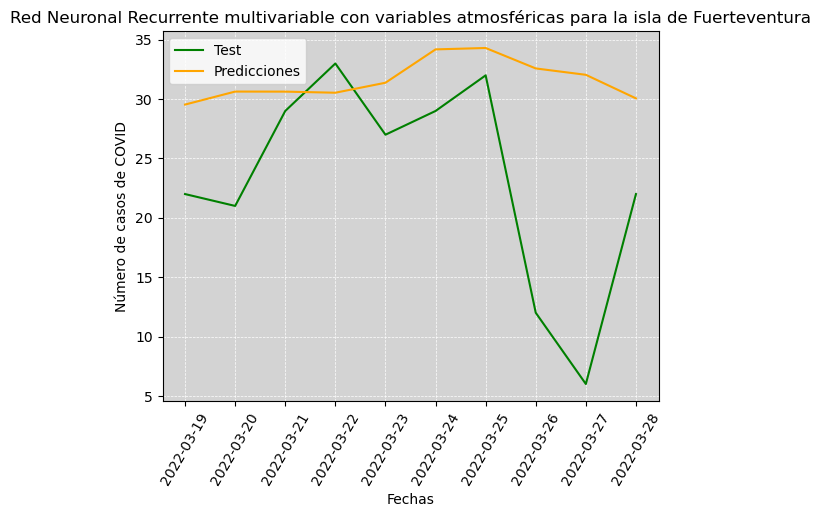

In [35]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [36]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([ -7.53826332,  -9.63398361,  -1.62934685,   2.46297073,
        -4.37789345,  -5.18767929,  -2.30537415, -20.58284378,
       -26.04613113,  -8.06065941])

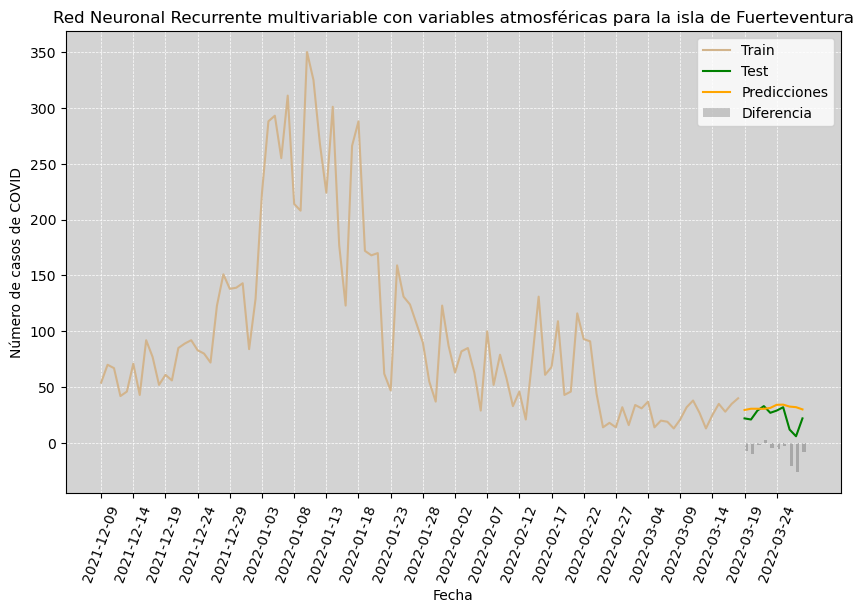

In [37]:
datos_train = datos_Fuerteventura_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [38]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 137.67814027784044
Error absoluto medio (MAE) del modelo: 8.782514572143555
Raíz del error cuadrático medio (RMSE) del modelo: 11.73363286786494


# Red Neuronal Recurrente multivariable con todas las variables

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Fuerteventura_mult_total_scaled = scaler.fit_transform(datos_Fuerteventura_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Fuerteventura_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Fuerteventura_mult_total[objetivo]).reshape(-1, 1))

In [40]:
n_train = len(datos_Fuerteventura_mult_total_scaled) - dias_prediccion


train = datos_Fuerteventura_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Fuerteventura_mult_total_scaled[n_train - dias_prediccion:len(datos_Fuerteventura_mult_total_scaled), :]

In [41]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [42]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0452 - val_loss: 0.0196 - 3s/epoch - 208ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0370 - val_loss: 0.0181 - 164ms/epoch - 12ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0308 - val_loss: 0.0189 - 157ms/epoch - 11ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0262 - val_loss: 0.0156 - 158ms/epoch - 11ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0241 - val_loss: 0.0157 - 156ms/epoch - 11ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0202 - val_loss: 0.0132 - 156ms/epoch - 11ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0195 - val_loss: 0.0139 - 157ms/epoch - 11ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0174 - val_loss: 0.0111 - 161ms/epoch - 11ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0174 - val_loss: 0.0120 - 159ms/epoch - 11ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0177 - val_loss: 0.0109 - 156ms/epoch - 11ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0147 - val_loss: 0.0100 - 157ms/epoch - 11ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0150 - val_loss: 0.0086 - 156ms/epoch - 11ms/step
Epoch 13/40
14/

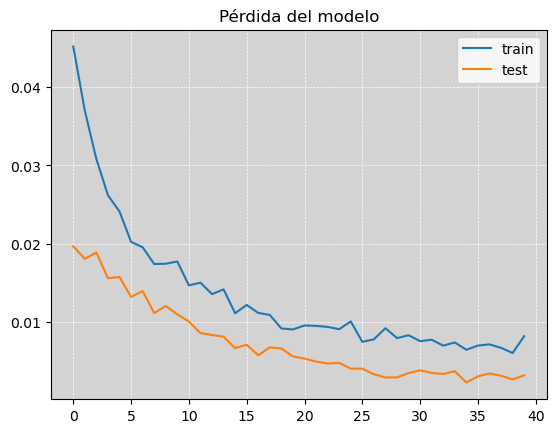

In [43]:
visualizar_perdida(historico)

In [44]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 288ms/step


In [45]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 22, número de casos predichos 11.225295
2022-03-20: número de casos reales 21, número de casos predichos 11.533925
2022-03-21: número de casos reales 28, número de casos predichos 11.440685
2022-03-22: número de casos reales 33, número de casos predichos 11.322127
2022-03-23: número de casos reales 27, número de casos predichos 11.297866
2022-03-24: número de casos reales 28, número de casos predichos 11.896724
2022-03-25: número de casos reales 32, número de casos predichos 11.7483835
2022-03-26: número de casos reales 12, número de casos predichos 11.21574
2022-03-27: número de casos reales 6, número de casos predichos 11.366465
2022-03-28: número de casos reales 22, número de casos predichos 11.34173


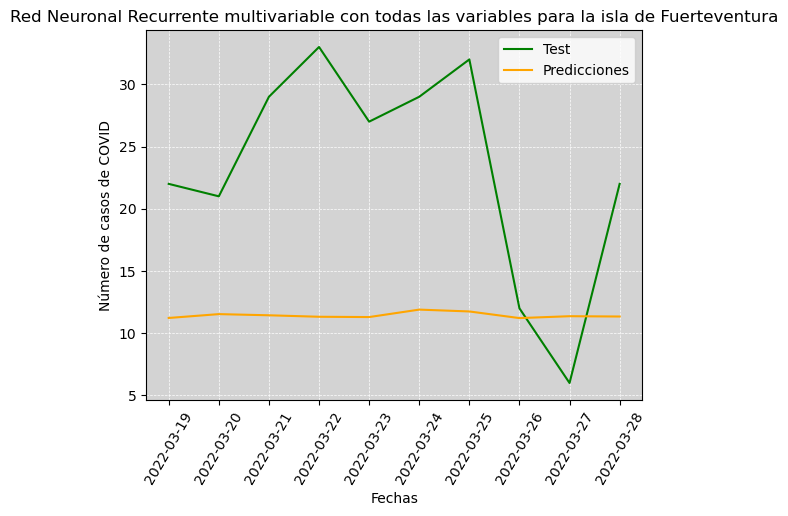

In [46]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [47]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([10.77470493,  9.46607494, 17.55931473, 21.67787266, 15.70213413,
       17.10327625, 20.25161648,  0.7842598 , -5.36646461, 10.65826988])

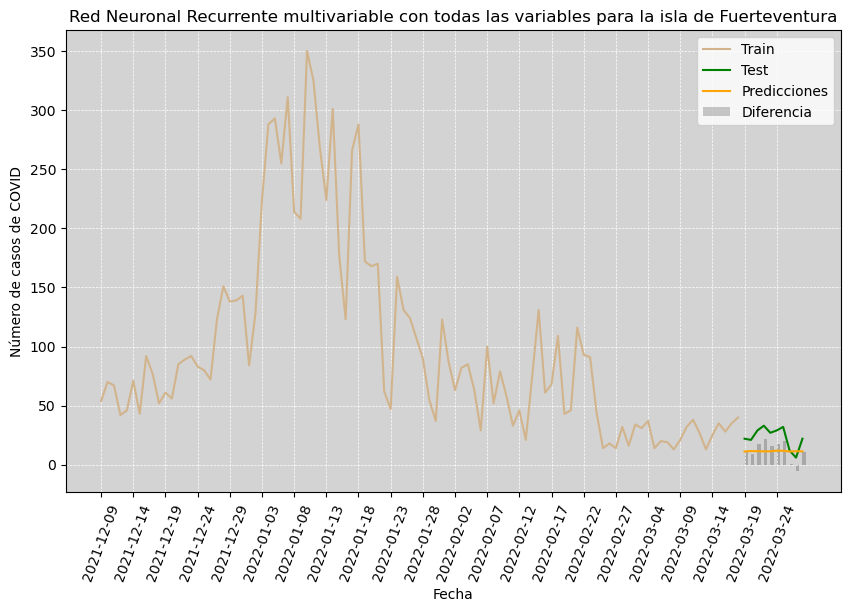

In [48]:
datos_train = datos_Fuerteventura_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [49]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 207.61803055418113
Error absoluto medio (MAE) del modelo: 12.93439884185791
Raíz del error cuadrático medio (RMSE) del modelo: 14.408956608796528
